In [15]:
# Importing Required Libraries
import numpy as np
import copy
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
import warnings
import pandas as pd
%matplotlib inline
warnings.filterwarnings('ignore')

In [16]:
# Reading the dataframe using pandas
data = pd.read_csv('Football.csv')

### Data Preprocessing

In [17]:
# Imputing the missing value of region record as the most common value
data['region'] = data['region'].fillna(2.)

In [18]:
data.head()

,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,12.0,17.10%,264,3.0,Chile,0,4,1,1,0
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,9.5,5.60%,167,2.0,Germany,0,4,1,1,0
2,Petr Cech,Arsenal,35,GK,4,7.0,1529,5.5,5.90%,134,2.0,Czech Republic,0,6,1,1,0
3,Theo Walcott,Arsenal,28,RW,1,20.0,2393,7.5,1.50%,122,1.0,England,0,4,1,1,0
4,Laurent Koscielny,Arsenal,31,CB,3,22.0,912,6.0,0.70%,121,2.0,France,0,4,1,1,0


In [19]:
class DataPreprocessing:
    def __init__(self,data):
        
        self.data = data
        self.cols_to_be_dropped = ['name','club_id','age_cat','nationality']
        self.cols_to_be_encoded = ['club','position','position_cat','region']
        
    def addPosCat(self,inputCat):

        if inputCat == 1:
            return('Attackers')
        elif inputCat == 2:
            return('Midfielders')
        elif inputCat == 3:
            return('Defenders')
        else:
            return('Goalkeeper')
        
    def addRegion(self, inpregion):
    
        if inpregion == 1:
            return('England')
        elif inpregion == 2:
            return('EU')
        elif inpregion == 3:
            return('Americans')
        else:
            return('Rest of World')
        
    def columnTypeConversion(self):
        
        # Converting fpl selection into numeric variable 
        self.data['fpl_sel'] = self.data['fpl_sel'].map(lambda x: str(x)[:-1]).astype('float')
        
    def logTransformation(self):
        
        # log transformation on page views variable as it has a high skew
        self.data['page_views'] = self.data['page_views'].apply(np.log)
        
    # Encoding the categorical variables using pandas dummies 
    def dataEncoding(self):

        self.data = pd.get_dummies(self.data, columns = self.cols_to_be_encoded, drop_first = True)
        
    def getProcessedData(self):
        self.data = self.data.drop(self.cols_to_be_dropped, inplace = False, axis = 1)
        self.data['position_cat'] = self.data['position_cat'].apply(self.addPosCat)
        self.data['region'] = self.data['region'].apply(self.addRegion)
        self.columnTypeConversion()
        self.dataEncoding()
        self.logTransformation()
        return self.data

In [20]:
data_obj = DataPreprocessing(data) 
encoded_data = data_obj.getProcessedData()

In [21]:
encoded_data.head()

,age,market_value,page_views,fpl_value,fpl_sel,fpl_points,new_foreign,big_club,new_signing,club_Bournemouth,...,position_RB,position_RM,position_RW,position_SS,position_cat_Defenders,position_cat_Goalkeeper,position_cat_Midfielders,region_EU,region_England,region_Rest of World
0,28,65.0,8.373092,12.0,17.1,264,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,28,50.0,8.388223,9.5,5.6,167,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,35,7.0,7.332369,5.5,5.9,134,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
3,28,20.0,7.780303,7.5,1.5,122,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,31,22.0,6.815640,6.0,0.7,121,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0


### Train Test Split

In [22]:
output_var = 'market_value'
X = encoded_data[encoded_data.columns[~encoded_data.columns.isin([output_var])]]
y = encoded_data[[output_var]]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
x_train = x_train.reset_index(drop = True)
x_test = x_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [23]:
# performin min max scaling on input data
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

### Model Building

In [24]:
# Fitting a Ridge Regressor
model = Ridge(alpha=0.1,max_iter=10000)
model.fit(x_train, y_train)

acc_train = model.score(x_train, y_train)
acc_test = model.score(x_test, y_test)
print("Accuracy on training data - " + str(acc_train))
print("Accuracy on test data - " + str(acc_test))
print()

train_pred = model.predict(x_train) 
test_pred = model.predict(x_test)
mse_train = mean_squared_error(y_train,train_pred)
mse_test = mean_squared_error(y_test,test_pred)
print("Root Mean Square Error on training data - " + str(mse_train**(0.5)))
print("Root Mean Square Error on test data - " + str(mse_test**(0.5)))

Accuracy on training data - 0.8171974505847125
Accuracy on test data - 0.7470230717320194

Root Mean Square Error on training data - 5.346724229127878
Root Mean Square Error on test data - 5.728102160586894


In [25]:
# fitting a support vector regressor
regr = SVR(C = 10000.0, epsilon=0.001, kernel='poly', degree=2)
regr.fit(x_train, y_train)

training_predictions = regr.predict(x_train)
test_predictions = regr.predict(x_test)
acc_train_svm = r2_score(y_train,training_predictions) 
acc_test_svm = r2_score(y_test, test_predictions)
print("Accuracy on training data - " + str(acc_train_svm))
print("Accuracy on test data - " + str(acc_test_svm))

Accuracy on training data - 0.9618659044095628
Accuracy on test data - 0.6980385157826382


### Hyperparameter Tuning

In [26]:
# Run for different values of lambda 
lambda_min = -7
lambda_max = 7

num_lambdas = 15

lambdas= np.linspace(lambda_min,lambda_max, num_lambdas)

train_r_squared = np.zeros(num_lambdas)
test_r_squared = np.zeros(num_lambdas)

In [27]:
for index, i in enumerate(lambdas):    
    # Fit ridge regression on train set
    model = Ridge(alpha = 10**i, max_iter=10000)
    model.fit(x_train, y_train)
       
    # Evaluate train & test performance
    train_r_squared[index] = model.score(x_train, y_train)
    test_r_squared[index] = model.score(x_test, y_test)
    

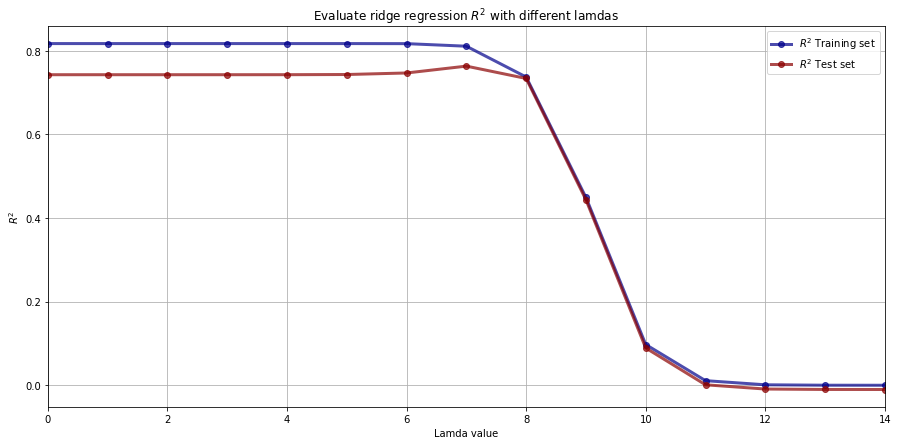

In [28]:
fig, axes = plt.subplots(figsize=(15,7))

axes.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.7, linewidth=3)
axes.plot(test_r_squared, 'ro-', label=r'$R^2$ Test set', color="darkred", alpha=0.7, linewidth=3)
axes.set_xlabel('Lamda value')
axes.set_ylabel(r'$R^2$')
axes.set_title(r'Evaluate ridge regression $R^2$ with different lamdas')
axes.set_xlim([0, 14])
plt.legend(loc='best')
plt.grid() 
plt.show()

### Conclusion
i) As the value of regularization constant increases variance of the model decreases upto a point after which the $R^2$ score on both training and test data starts dropping.<br>
ii) The regularization constant value 1 seems to be a good value 

In [29]:
# Run for different values of C 
num_C = 9
C_param = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

train_r_squared = np.zeros(num_C)
test_r_squared = np.zeros(num_C)

In [30]:
for index, i in enumerate(C_param):    
    
    # Fit support vector regression on train set
    regr = SVR(C = i, epsilon=0.0001, kernel='poly', degree=2)
    regr.fit(x_train, y_train)

    # Evaluate train & test performance
    training_predictions = regr.predict(x_train)
    test_predictions = regr.predict(x_test)
    train_r_squared[index] = r2_score(y_train, training_predictions)
    test_r_squared[index] = r2_score(y_test, test_predictions)

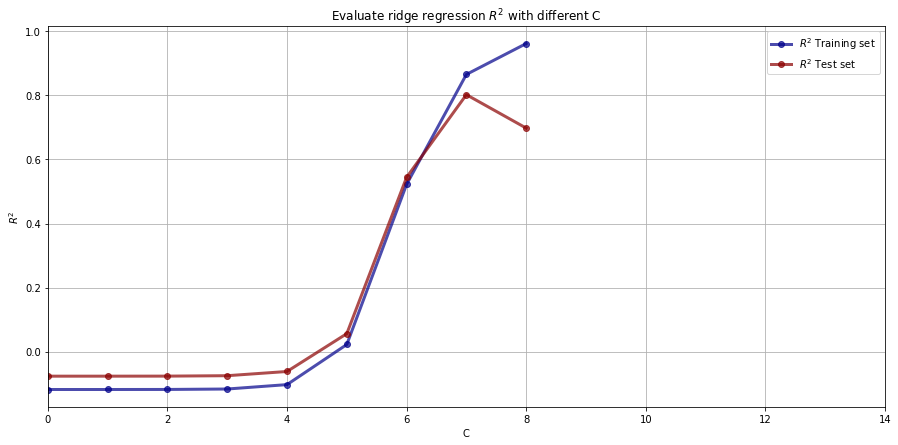

In [31]:
# Plotting
plt.figure(figsize=(15, 7))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.7, linewidth=3)
plt.plot(test_r_squared, 'ro-', label=r'$R^2$ Test set', color="darkred", alpha=0.7, linewidth=3)
plt.xlabel('C')
plt.ylabel(r'$R^2$')
plt.xlim(0,14)
plt.title(r'Evaluate ridge regression $R^2$ with different C')
plt.legend(loc='best')
plt.grid()

### Conclusion
i) As the value of C increases the $R^2$ value increases for both training and test set but after a certain value the model starts overfitting.<br>
ii) The best value of C seems to be 1000

In [32]:
# Run for different values of C 
epsilon_nums = 8
epsilon_vals = [0.00001,0.0001,0.001,0.01,0.1,1,10,100]

train_r_squared = np.zeros(epsilon_nums)
test_r_squared = np.zeros(epsilon_nums)

In [33]:
for index, i in enumerate(epsilon_vals):    
    
    # Fit support vector regression on train set
    regr = SVR(C = 10000, epsilon=i, kernel='poly', degree=2)
    regr.fit(x_train, y_train)

    # Evaluate train & test performance
    training_predictions = regr.predict(x_train)
    test_predictions = regr.predict(x_test)
    train_r_squared[index] = r2_score(y_train, training_predictions)
    test_r_squared[index] = r2_score(y_test, test_predictions)

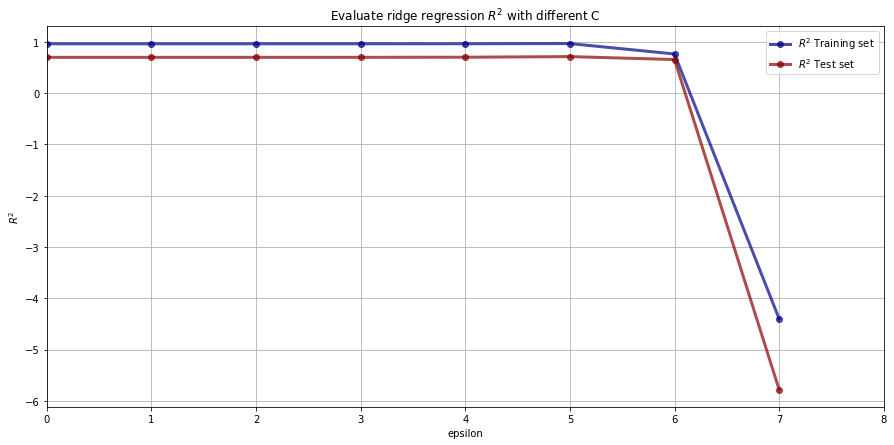

In [34]:
# Plotting
plt.figure(figsize=(15, 7))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.7, linewidth=3)
plt.plot(test_r_squared, 'ro-', label=r'$R^2$ Test set', color="darkred", alpha=0.7, linewidth=3)
plt.xlabel('epsilon')
plt.ylabel(r'$R^2$')
plt.xlim(0,8)
plt.title(r'Evaluate ridge regression $R^2$ with different C')
plt.legend(loc='best')
plt.grid()

### Conclusion
i) As the value of epsilon increases the $R^2$ value remains close to one another for both training and test set but after a certain value the model starts underfitting.<br>
ii) The best value of epsilon seems to be 0.0001

### Finalized Models

In [35]:
# Ridge Regression Model
model = Ridge(alpha=1,max_iter=10000)
model.fit(x_train, y_train)

acc_train = model.score(x_train, y_train)
acc_test = model.score(x_test, y_test)
print("R_2 score of training data - " + str(acc_train))
print("R_2 score of test data - " + str(acc_test))

R_2 score of training data - 0.8110360929183491
R_2 score of test data - 0.7634074142173044


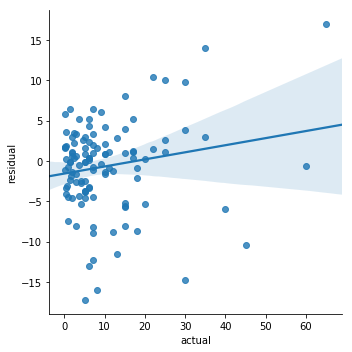

Root Mean Square Error:  5.539503778583439


In [36]:
pred = model.predict(x_test)
residual = y_test - pred
df = pd.DataFrame(np.concatenate([y_test,pred,residual],axis = 1),columns =['actual','predicted','residual'])
sns.lmplot(x='actual',y='residual',data=df)
plt.show()
print("Root Mean Square Error: ",np.sqrt(1/df.shape[0]*(df.residual).dot(df.residual)))

In [37]:
# support vector regression model
regr = SVR(C = 10000.0, epsilon=0.0001, kernel='poly', degree=2)
regr.fit(x_train, y_train)

training_predictions = regr.predict(x_train)
test_predictions = regr.predict(x_test)
acc_train_svm = r2_score(y_train,training_predictions) 
acc_test_svm = r2_score(y_test, test_predictions)
print("R_2 score of training data - " + str(acc_train_svm))
print("R_2 score of test data - " + str(acc_test_svm))

R_2 score of training data - 0.9618566698231465
R_2 score of test data - 0.6980016253921137


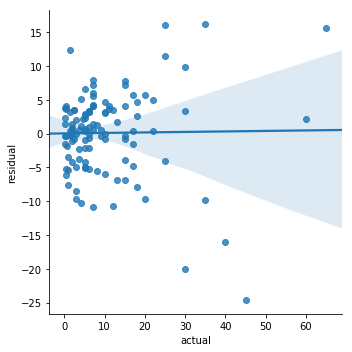

Root Mean Square Error:  6.2585337751423396


In [38]:
pred = regr.predict(x_test)
pred = pred.reshape(pred.shape[0],1)
residual = y_test - pred
df = pd.DataFrame(np.concatenate([y_test,pred,residual],axis = 1),columns =['actual','predicted','residual'])
sns.lmplot(x='actual',y='residual',data=df)
plt.show()
print("Root Mean Square Error: ",np.sqrt(1/df.shape[0]*(df.residual).dot(df.residual)))

In [39]:
neigh = KNeighborsRegressor(n_neighbors=10)
neigh.fit(x_train, y_train)

print("R_2 score of training data - " + str(neigh.score(x_train,y_train)))
print("R_2 score of test data - " + str(neigh.score(x_test,y_test)))

R_2 score of training data - 0.6228983531309685
R_2 score of test data - 0.5857344441081738


### Genetic Algorithm 

In [94]:
class GeneticAlgorithm :
    
    def __init__(self, num_chromosomes, num_genes):
        self.num_chromosomes = num_chromosomes
        self.num_genes = num_genes
        self.population = np.random.uniform(low=-3.0, high=3.0, size=(self.num_chromosomes, self.num_genes))
        
    def crossOver(self, parent1_idx, parent2_idx):
        Pc_threshold = 0.3
        Pc = np.random.uniform(0,1)
        
        # If crossover probability is less than or equal to threshold then do crossover operation
        if Pc <= Pc_threshold:
            
            # The point at which crossover takes place between two parents. Usually, it is at the center.
            crossover_point = np.uint8(self.num_genes/2)
            
            # flipping the second halves of parent chromosomes
            temp = self.population[parent1_idx, crossover_point:].copy()
            self.population[parent1_idx, crossover_point:] = self.population[parent2_idx, crossover_point:]
            self.population[parent2_idx, crossover_point:] = temp.copy()
            
            

    
    def select_mating_pool(self, fitness_val):
    
        # Selecting the best individuals in the current generation as parents 
        # for producing the offspring of the next generation.
        
        select_probs  = fitness_val + 1
        select_probs = select_probs / select_probs.sum()
        fitness_based_selected =  np.random.choice(fitness_val.squeeze(), size = fitness_val.shape[0], replace = False, p = select_probs.squeeze())
        
        for i in range(fitness_based_selected.shape[0]//2):
            parent_fit_1 = fitness_based_selected[(i*2)]
            parent_fit_2 = fitness_based_selected[(i*2) + 1]
            parent1_idx = np.where(fitness_val == parent_fit_1)[0][0]
            parent2_idx = np.where(fitness_val == parent_fit_2)[0][0]
            
            # Doing Cross over operation
            self.crossOver(parent1_idx, parent2_idx)
            
            # Doing Mutation Operation
            self.mutation(parent1_idx, parent2_idx)
            
    
    # Mutation changes a single gene in each offspring randomly.
    def mutation(self, parent1_idx, parent2_idx):
        Mc_threshold = 0.08
        Mc = np.random.uniform(0,1)
        
        # If mutation probability is less than or equal to threshold then do mutation operation
        if Mc <= Mc_threshold:
            
            # The random value to be added to the gene.
            random_value = np.random.uniform(-1.0, 1.0, 1)
            
            # the random gene whose value is to be changed
            gene_idx = np.random.randint(1,self.num_genes + 1, 1)
            self.population[parent1_idx, gene_idx] = self.population[parent1_idx, gene_idx] + random_value
            self.population[parent2_idx, gene_idx] = self.population[parent2_idx, gene_idx] + random_value
            
            
        
    def fitnessEvaluation(self, x_train, y_train):
        fitness = np.zeros((self.population.shape[0],1))
        for index, item in enumerate(self.population):
            kfold = KFold(n_splits=5, random_state=2)
            neigh = KNeighborsRegressor(n_neighbors=15,metric = 'wminkowski', metric_params = {'w':item})
            fitness[index] = cross_val_score(neigh, x_train, y_train, cv=kfold, scoring="r2").mean()
        return fitness
        
    def generation(self, x_train, y_train):
        num_generations = 10
        for generation in range(num_generations):
            # Measuring the fitness of each chromosome in the population
            fitness_val = self.fitnessEvaluation(x_train, y_train)
            # Selecting the best parents in the population for mating.
            self.select_mating_pool(fitness_val)
            
        # returning the most fit chromosome and its fitness from the final population
        return self.population[np.argmax(fitness_val)], np.max(fitness_val)

In [101]:
obj = GeneticAlgorithm(20,45)
wts, fitness = obj.generation(x_train, y_train)
print("The fitness value of fittest chromosome in the final population is "+ str(fitness))

The fitness value of fittest chromosome in the final population is 0.5506875899111945


In [102]:
# Using the weights learnt from the Genetic Algorithm in KNN regressor model to improve on its accuracy
neigh = KNeighborsRegressor(n_neighbors=15,metric = 'wminkowski', metric_params = {'w':wts})
neigh.fit(x_train, y_train)

print("R_2 score of training data - " + str(neigh.score(x_train,y_train)))
print("R_2 score of test data - " + str(neigh.score(x_test,y_test)))

train_pred = neigh.predict(x_train) 
test_pred = neigh.predict(x_test)
mse_train = mean_squared_error(y_train,train_pred)
mse_test = mean_squared_error(y_test,test_pred)
print("Root Mean Square Error on training data - " + str(mse_train**(0.5)))
print("Root Mean Square Error on test data - " + str(mse_test**(0.5)))

R_2 score of training data - 0.6036502448552139
R_2 score of test data - 0.6252018497920893
Root Mean Square Error on training data - 7.872922164853951
Root Mean Square Error on test data - 6.972186842577879
